# Historical Consistent Neural Network with known features

In this notebook we demonstrate how the prosper_nn package can be used to build and analyze a Historical Consistent Neural Network (HCNN) with (partly) known features.
Similar to the other tutorials, it begins with a simple version of an HCNN_known_u and shows how the data and the training loop should look like.
If you want to build an ensemble please refer to [HCNN tutorial](HCNN.ipynb#Ensemble-of-Historical-Consistent-Neural-Networks). 

## Theory

Historical Consistent Neural Networks with known features U are based on the architectures of HCNNs and ECNNs. As a result it belongs to the class of Recurrent Neural Networks. The picture below shows the architecture of the model.

The common HCNN model treats all features as targets and forecasts them into the future. The version of the HCNN presented in this notebook, however, distinguishes between features we want to forecast and features we already know for the future (like e.g. holidays or months). The latter is what 'known U' refers to. As a result, we use all the advantages of the common HCNN while also utilizing our known information to capacity. Instead of trying to forecast holidays in the HCNN (and failing), we provide the model with this information even along the forecast horizon. In a way, this model is like a combination of HCNN (model features internally if we don't know them for the future) and ECNN (supply the model with external features if we know them for the future).

We facilitate the inclusion of known features by concatenating them to the state $r$. These known features are used for calculating the next state but are themselves not modeled as part of the next state. This is why $dim(r_t) = (batchsize, n\_state\_neurons + n\_features\_U)$ whereas $dim(s_t) = (batchsize, n\_state\_neurons)$. Accordingly, $dim(A) = ((n\_state\_neurons + n\_features\_U) , n\_state\_neurons)$.

To calculate the state of the next time step, a non-linearity ($\tanh$) and the state transition matrix $A$ are applied. These update steps describe the implementation of the HCNN_known_u cell that calculates the output and the following state for one time step. In formula each cell performs the following calculation.
For readability we use these abbreviations:
 - nst = n_state_neurons 
 - nfY = n_features_Y 
 - nfU = n_features_U 

$$\hat{z}_t =  [\mathbb{I}_{nfY}, \mathbb{0}_{nst-nfY}] s_t -y_t^d$$
$$r_t = [\mathbb{I}_{nst}, \mathbb{0}_{nst, nfU}]^T \cdot s_t - [\mathbb{I}_{nfY}, \mathbb{0}_{nfY, nst-nfY}, \mathbb{0}_{nfY, nfU}]^T \cdot \hat{z}_t  + [\mathbb{0}_{nfU, nst}, \mathbb{I}_{nfU}]^T u_{t+1} $$
$$  
s_{t+1} = A \tanh (r_t)  $$
$$ y_t = [\mathbb{I}_{nfY}, \mathbb{0}_{nst-nfY}] \cdot s_t  $$
The first part of $r$ contains the data, the middle portion the hidden features and the end the info from the external features U.


<img src=images/Hcnn_known_u.png width=1000 >

In [1]:
import sys, os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from prosper_nn.models.hcnn_known_u import hcnn_known_u
from prosper_nn.models.ensemble import Ensemble

import prosper_nn.utils.generate_time_series_data as gtsd
import prosper_nn.utils.create_input_ecnn_hcnn as ci

import prosper_nn.utils.neuron_correlation_hidden_layers as nchl
import prosper_nn.utils.visualization as visualization
from prosper_nn.utils import visualize_forecasts
from prosper_nn.utils import sensitivity_analysis
torch.manual_seed(0)

## Data Preparation 

For the data creation look at the [ECNN tutorial](ECNN.ipynb#Data-preparation).
If we set `n_features_U` to zero, we would revert this architecture back to vanilla HCNN. 

In [3]:
past_horizon = 30
forecast_horizon = 5
n_features_U = 2
n_features_Y = 3
future_U = True
batchsize = 5
n_batches = 4
n_data = 100

For HCNN_known_u the target data should be in the `shape=(past_horizon, batchsize, n_features_Y)` and the external features which are known for the future in the shape `shape=(past_horizon + forecast_horizon, batchsize, n_features_U)`. 

In [4]:
# generate data with n_features_U and n_features_Y
Y, U = gtsd.sample_data(n_data, n_features_Y, n_features_U)
Y_batches, U_batches = ci.create_input(
    Y, past_horizon, batchsize, U, future_U, forecast_horizon
)

c:\Users\bkn\Projekte\Prosper\prosper\prosper_nn\utils\create_input_ecnn_hcnn.py:57: UserWarning: For the last values of Y there are not enough future Us, so they will be discarded.
  warnings.warn("For the last values of Y there are not enough "
C:\Users\bkn\AppData\Local\Temp\ipykernel_19076\3361968738.py:3: UserWarning: The number of sequences generated from the data are not a multiple of batchsize. The first 1 sequences will be discarded.
  Y_batches, U_batches = ci.create_input(


Equal to HCNN, the targets of the HCNN_known_u should be in the same shape as $Y$, that is `shape=(past_horizon, batchsize, n_features_Y)`. Because the output of the HCNN_known_u is already the comparison between observation and expectation in the past horizon, the targets are zeros.

In [5]:
targets = torch.zeros((past_horizon, batchsize, n_features_Y))

## Single Historical Consistent Neural Network with known features (HCNN_known_u) 

In this section, we apply a HCNN with known features. We first start with the initialization of the model. Then we discuss the training loop and create forecasts for the data we generated. At the end of the section we evaluate the model and analyze it.

### Initialization

Compared to the [HCNN](../api/hcnn.rst) we only have to specify the `n_featues_U` additionally.

In [6]:
n_state_neurons = 30
sparsity = 0

In [7]:
hcnn_known_u_model = hcnn_known_u.HCNN_KNOWN_U(
    n_state_neurons,
    n_features_U,
    n_features_Y,
    past_horizon,
    forecast_horizon,
    sparsity,
)

Set optimizer and loss function.

In [8]:
optimizer = optim.Adam(hcnn_known_u_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

### Training Loop

In this training loop the output of the HCNN_known_u has `shape=(past_horizon + forecast_horizon, batchsize, n_features_Y)`. So there is no difference to the basic HCNN and we only have to give the `U_batch` in the forward of the model.

In [9]:
epochs = 150

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, U_batches.shape[0]):
        hcnn_known_u_model.zero_grad()

        U_batch = U_batches[batch_index]
        Y_batch = Y_batches[batch_index]

        model_out = hcnn_known_u_model(U_batch, Y_batch)

        past_error, forecast = torch.split(model_out, past_horizon)

        losses = [loss_function(past_error[i], targets[i]) for i in range(past_horizon)]
        loss = sum(losses)
        loss.backward()
        
        optimizer.step()
        total_loss[epoch] += loss.detach()


### Forecast 

For a final prediction we only need to forward the U and Y we want to use for the actual forecast through the model. Again, we get the forecast and also the error the model still makes on the known Y.

In [10]:
example_pred_U = torch.reshape(
    U[0 : (past_horizon + forecast_horizon), :],
    (past_horizon + forecast_horizon, 1, n_features_U),
).float()
example_pred_Y = torch.reshape(
    Y[0 : (past_horizon + forecast_horizon), :],
    (past_horizon + forecast_horizon, 1, n_features_Y),
).float()

with torch.no_grad():
    hcnn_known_u_model.eval()

    model_output = hcnn_known_u_model(example_pred_U, example_pred_Y[:past_horizon])
    past_errors, forecast = torch.split(model_output, past_horizon)


### Evaluation
#### Postprocessing
Because the output of the model has different meaning for `past_horizon` and `forecast_horizon`, the `expected_timeseries` can be calculated by adding the real observation data `Y` on the `past_error` for the `past_horizon` and concatenate the result to the `forecast` of the model.

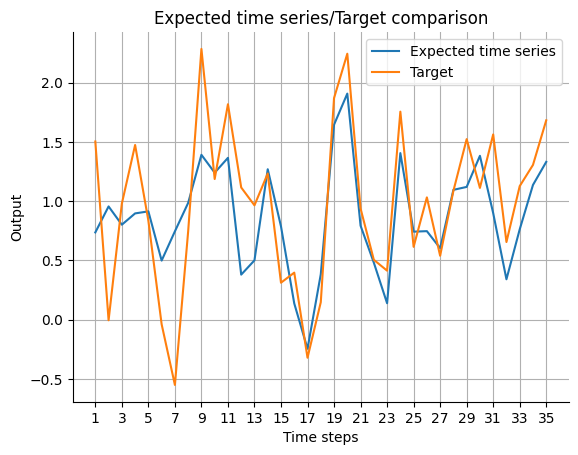

In [11]:
expected_timeseries = torch.cat(
    (torch.add(past_errors.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: past_horizon + forecast_horizon, 0],
)